In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit, KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import catboost as ctb

import sys


from functools import partial

import eli5
from eli5.sklearn import PermutationImportance
import tqdm


import h5py 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

**Dane**
**Sales** - Historyczne dane sprzedaży.

- **store** - store number (store can have one or more departments)
- **dept** - department number
- **date** -  week (data is collected in weekly groups)
- **weekly_sales** - sales for a given department in a given store
- **is_holiday** - whether the week is a special week (holiday).

In [2]:
df_sales = pd.read_hdf('./input/sales.h5', index_col=0)
df_sales= df_sales.set_index('id')

In [3]:
df_sales.sample(5)

,weekly_sales,store,dept,date,is_holiday
id,,,,,
11942,57540.121094,2,8,30/04/2010,False
275230,1264.520020,32,31,15/04/2011,False
410556,7710.709961,19,21,02/09/2011,False
275465,6454.700195,40,25,15/07/2011,False
375903,3214.899902,25,26,17/06/2011,False


**Cechy dodatkowe** - Contain additional data related to store, department, and regional activity for the given time periods.

- **store** - the store number,,
- **date-week** (data is collected in weekly groups),
- **temperature** -average temperature in the region,
- **fuel_price** - fuel cost in the region,
- **mark_down1-5** - anonymized data related to promotional markdowns. Mark down data is only available after November 2011 and is not available for all stores all the time. Any missing values are marked NA.
- **cpi** - the consumer price index,
- **unemployment** - unemployment rate,
- **is_holiday** - whether the week is a special holiday week.

In [4]:
df_features = pd.read_hdf('./input/features.h5', index_col=0)

In [5]:
df_features.sample(5)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday
6245,35,11/03/2011,6.464844,3.582031,NaN,NaN,NaN,NaN,NaN,137.625,8.546875,False
1128,7,15/10/2010,2.144531,2.761719,NaN,NaN,NaN,NaN,NaN,190.875,9.140625,False
3107,18,07/05/2010,18.687500,2.980469,NaN,NaN,NaN,NaN,NaN,132.125,9.265625,False
5676,32,01/10/2010,18.968750,2.759766,NaN,NaN,NaN,NaN,NaN,190.625,9.140625,False
5704,32,15/04/2011,7.761719,3.611328,NaN,NaN,NaN,NaN,NaN,192.375,8.593750,False


**Store** - Information about the type and size of the store.

In [6]:
df_store = pd.read_csv("./input/stores_data.csv", index_col=0)

In [7]:
df_store.sample(5)

,Type,Size
Store,,
7,B,70713
34,A,158114
45,B,118221
18,B,120653
3,B,37392


#### Merging dataframes

In [8]:
merged_df = df_sales.merge(df_features, how='left', on=['store', 'is_holiday', 'date'])

#merged_df = merged_df.merge(df_store, how='left', on='store')

In [9]:
merged_df

,weekly_sales,store,dept,date,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment
0,41272.601562,42,94,09/07/2010,False,32.781250,3.099609,NaN,NaN,NaN,NaN,NaN,126.125,9.195312
1,6212.770020,19,32,19/08/2011,False,21.750000,3.941406,NaN,NaN,NaN,NaN,NaN,136.125,7.804688
2,32530.310547,45,7,10/06/2011,False,23.265625,3.880859,NaN,NaN,NaN,NaN,NaN,185.625,8.523438
3,6199.310059,12,71,20/05/2011,False,19.218750,4.167969,NaN,NaN,NaN,NaN,NaN,129.125,13.734375
4,4262.890137,29,24,10/09/2010,True,20.328125,2.716797,NaN,NaN,NaN,NaN,NaN,132.750,10.406250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285084,3727.000000,13,19,19/02/2010,False,2.054688,2.654297,NaN,NaN,NaN,NaN,NaN,126.500,8.312500
285085,42387.859375,19,8,16/07/2010,False,23.671875,2.933594,NaN,NaN,NaN,NaN,NaN,132.625,8.101562
285086,3365.510010,25,12,12/08/2011,False,21.625000,3.812500,NaN,NaN,NaN,NaN,NaN,208.750,7.273438
285087,6652.979980,5,9,13/05/2011,False,25.218750,3.898438,NaN,NaN,NaN,NaN,NaN,216.500,6.488281


In [10]:
merged_df = merged_df.merge(df_store, left_on='store', right_index=True, how='left')
merged_df.sample(5)

,weekly_sales,store,dept,date,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,Type,Size
272022,175.619995,1,59,15/07/2011,False,31.406250,3.574219,NaN,NaN,NaN,NaN,NaN,215.375,7.960938,A,151315
15209,26220.789062,32,46,29/04/2011,False,7.144531,3.662109,NaN,NaN,NaN,NaN,NaN,192.625,8.593750,A,203007
161311,26461.480469,18,4,04/02/2011,False,-6.226562,3.240234,NaN,NaN,NaN,NaN,NaN,133.125,9.132812,B,120653
172263,5885.899902,9,74,19/11/2010,False,9.976562,2.771484,NaN,NaN,NaN,NaN,NaN,215.375,6.558594,B,125833
242926,18.000000,26,54,01/10/2010,False,14.335938,2.716797,NaN,NaN,NaN,NaN,NaN,132.750,8.148438,A,152513


In [11]:
#### Importing merged dataframe

In [12]:
merged_df.to_csv('./input/merged_data.csv')

In [13]:
#### Finding information about the dataframe

In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285089 entries, 0 to 285088
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   weekly_sales  285089 non-null  float32
 1   store         285089 non-null  int8   
 2   dept          285089 non-null  int8   
 3   date          285089 non-null  object 
 4   is_holiday    285089 non-null  bool   
 5   temperature   285089 non-null  float16
 6   fuel_price    285089 non-null  float16
 7   mark_down1    14710 non-null   float16
 8   mark_down2    12455 non-null   float16
 9   mark_down3    14422 non-null   float16
 10  mark_down4    12898 non-null   float16
 11  mark_down5    14951 non-null   float16
 12  cpi           285089 non-null  float16
 13  unemployment  285089 non-null  float16
 14  Type          285089 non-null  object 
 15  Size          285089 non-null  int64  
dtypes: bool(1), float16(9), float32(1), int64(1), int8(2), object(2)
memory usage: 15.5+ MB


In [15]:
#### Changing columns Dtypes and setting date column as index

In [16]:
merged_df["date"] = pd.to_datetime(merged_df["date"], dayfirst=True)

In [17]:
merged_df = merged_df.set_index('date')

**Every column have to contain numeric dtype of data!**

In [18]:
### From boolean dtype to {0,1}
merged_df['is_holiday'].replace({False: 0, True: 1}, inplace=True)

In [19]:
merged_df['Type'].unique() #There are three types => {A,B,C}

# We have to create dummy variables 

Type = merged_df[['Type']]
merged_df.drop('Type', axis=1, inplace=True)

In [20]:
Type_dummies = pd.get_dummies(Type, drop_first=True)

# We will use drop_first=True to not create Type_A column
# This will reduce dimensionality to 2 columns
# and will carry the same amount of information as 3 columns

Type_dummies.sample(5)

,Type_B,Type_C
date,,
2010-07-02,0,1
2011-01-07,1,0
2010-04-30,0,0
2011-08-12,0,0
2010-07-09,1,0


In [21]:
#Merging merged_df and Type_dummies

merged_df = pd.concat([merged_df,Type_dummies], axis=1)

In [22]:
merged_df

,weekly_sales,store,dept,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,Size,Type_B,Type_C
date,,,,,,,,,,,,,,,,
2010-07-09,41272.601562,42,94,0,32.781250,3.099609,NaN,NaN,NaN,NaN,NaN,126.125,9.195312,39690,0,1
2011-08-19,6212.770020,19,32,0,21.750000,3.941406,NaN,NaN,NaN,NaN,NaN,136.125,7.804688,203819,0,0
2011-06-10,32530.310547,45,7,0,23.265625,3.880859,NaN,NaN,NaN,NaN,NaN,185.625,8.523438,118221,1,0
2011-05-20,6199.310059,12,71,0,19.218750,4.167969,NaN,NaN,NaN,NaN,NaN,129.125,13.734375,112238,1,0
2010-09-10,4262.890137,29,24,1,20.328125,2.716797,NaN,NaN,NaN,NaN,NaN,132.750,10.406250,93638,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-19,3727.000000,13,19,0,2.054688,2.654297,NaN,NaN,NaN,NaN,NaN,126.500,8.312500,219622,0,0
2010-07-16,42387.859375,19,8,0,23.671875,2.933594,NaN,NaN,NaN,NaN,NaN,132.625,8.101562,203819,0,0
2011-08-12,3365.510010,25,12,0,21.625000,3.812500,NaN,NaN,NaN,NaN,NaN,208.750,7.273438,128107,1,0


In [23]:
merged_df.info() #Now all features have numeric dtype

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285089 entries, 2010-07-09 to 2010-11-19
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   weekly_sales  285089 non-null  float32
 1   store         285089 non-null  int8   
 2   dept          285089 non-null  int8   
 3   is_holiday    285089 non-null  int64  
 4   temperature   285089 non-null  float16
 5   fuel_price    285089 non-null  float16
 6   mark_down1    14710 non-null   float16
 7   mark_down2    12455 non-null   float16
 8   mark_down3    14422 non-null   float16
 9   mark_down4    12898 non-null   float16
 10  mark_down5    14951 non-null   float16
 11  cpi           285089 non-null  float16
 12  unemployment  285089 non-null  float16
 13  Size          285089 non-null  int64  
 14  Type_B        285089 non-null  uint8  
 15  Type_C        285089 non-null  uint8  
dtypes: float16(9), float32(1), int64(2), int8(2), uint8(2)
memory usage: 13.6 MB

In [24]:
#### Dealing with missing values

In [25]:
merged_df.isna().any()

weekly_sales    False
store           False
dept            False
is_holiday      False
temperature     False
fuel_price      False
mark_down1       True
mark_down2       True
mark_down3       True
mark_down4       True
mark_down5       True
cpi             False
unemployment    False
Size            False
Type_B          False
Type_C          False
dtype: bool

In [26]:
percent_missing = merged_df.isnull().sum()*100/len(merged_df)
percent_missing

weekly_sales     0.000000
store            0.000000
dept             0.000000
is_holiday       0.000000
temperature      0.000000
fuel_price       0.000000
mark_down1      94.840208
mark_down2      95.631189
mark_down3      94.941229
mark_down4      95.475799
mark_down5      94.755673
cpi              0.000000
unemployment     0.000000
Size             0.000000
Type_B           0.000000
Type_C           0.000000
dtype: float64

**From description of our data we know that mark_down1-5 mostly contain nan values because zanonimizowane dane związane z promocyjnymi obniżkami cen. Dane mark_down są dostępne dopiero po listopadzie 2011.

Text(0.5, 1.0, 'mark_down 5')

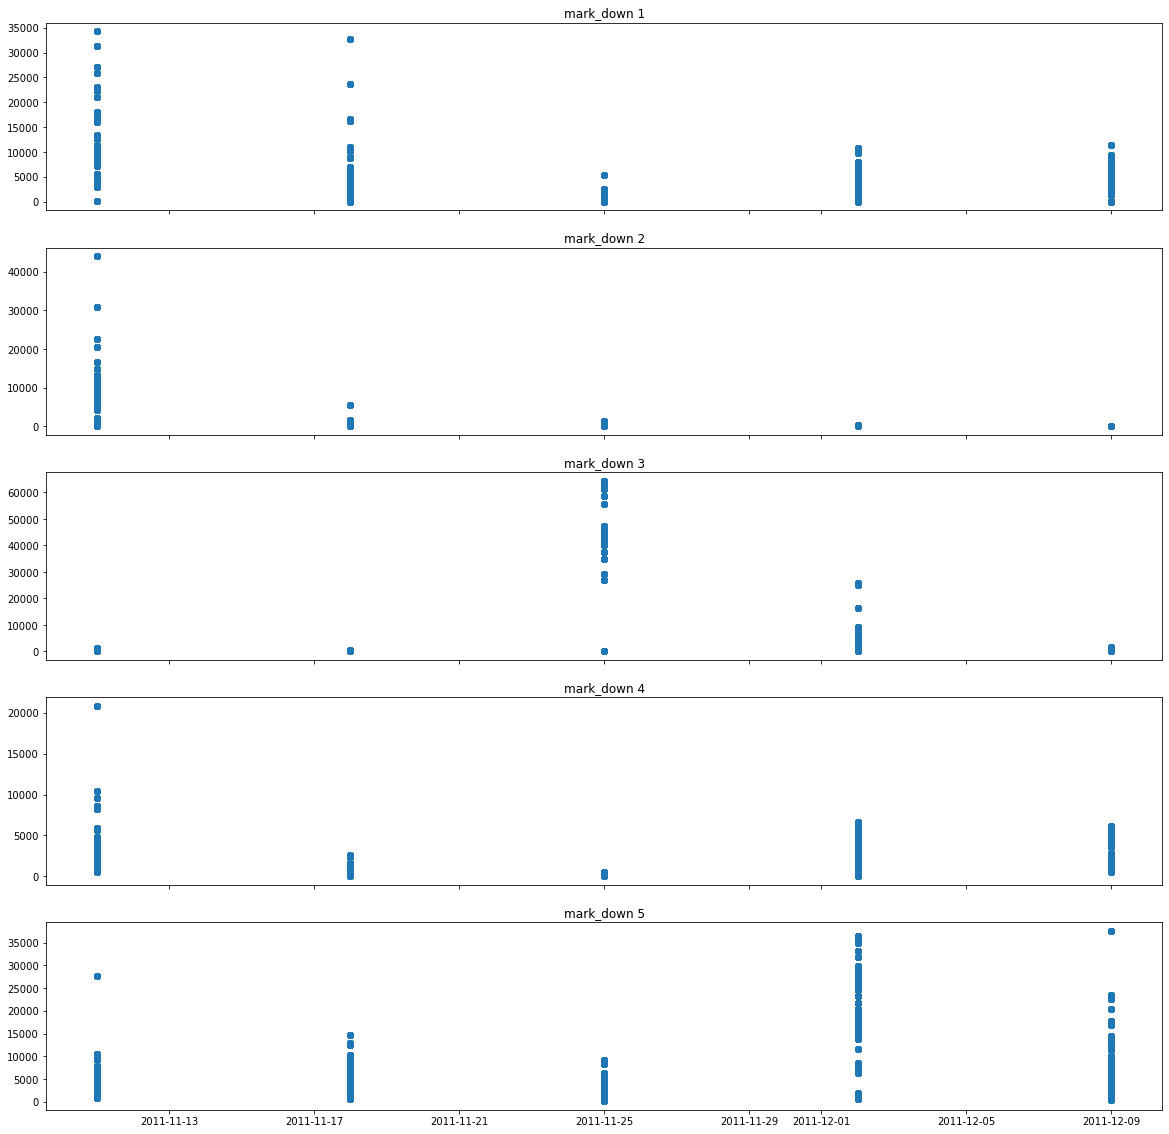

In [27]:
fig, [ax1, ax2, ax3, ax4, ax5]= plt.subplots(5,1, figsize=(20,20), sharex=True)

ax1.scatter(merged_df.index,merged_df.mark_down1)
ax1.set_title('mark_down 1')

ax2.scatter(merged_df.index,merged_df.mark_down2)
ax2.set_title('mark_down 2')

ax3.scatter(merged_df.index,merged_df.mark_down3)
ax3.set_title('mark_down 3')

ax4.scatter(merged_df.index,merged_df.mark_down4)
ax4.set_title('mark_down 4')

ax5.scatter(merged_df.index,merged_df.mark_down5)
ax5.set_title('mark_down 5')

In [28]:
# Over 96 % of mark_down1-5 are nan values! 
# We hae to drop that columns!

merged_df.drop(['mark_down1','mark_down2','mark_down3','mark_down4','mark_down5'], axis=1, inplace=True)

In [29]:
merged_df

,weekly_sales,store,dept,is_holiday,temperature,fuel_price,cpi,unemployment,Size,Type_B,Type_C
date,,,,,,,,,,,
2010-07-09,41272.601562,42,94,0,32.781250,3.099609,126.125,9.195312,39690,0,1
2011-08-19,6212.770020,19,32,0,21.750000,3.941406,136.125,7.804688,203819,0,0
2011-06-10,32530.310547,45,7,0,23.265625,3.880859,185.625,8.523438,118221,1,0
2011-05-20,6199.310059,12,71,0,19.218750,4.167969,129.125,13.734375,112238,1,0
2010-09-10,4262.890137,29,24,1,20.328125,2.716797,132.750,10.406250,93638,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2010-02-19,3727.000000,13,19,0,2.054688,2.654297,126.500,8.312500,219622,0,0
2010-07-16,42387.859375,19,8,0,23.671875,2.933594,132.625,8.101562,203819,0,0
2011-08-12,3365.510010,25,12,0,21.625000,3.812500,208.750,7.273438,128107,1,0


Text(0.5, 1.0, 'weekly_sales')

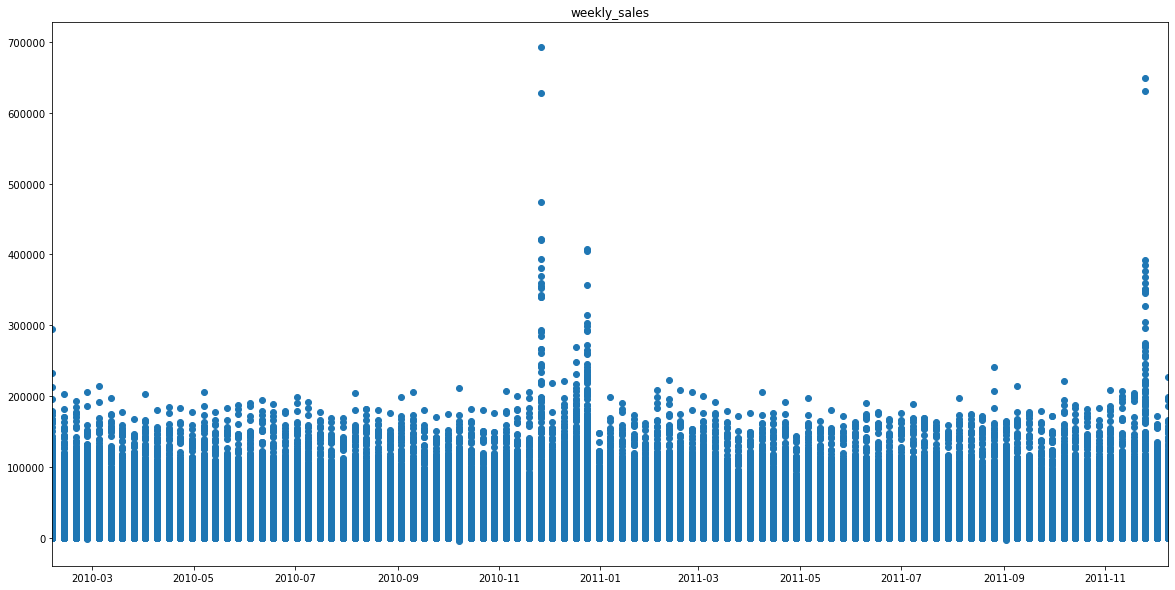

In [30]:
### Dealing with nan values in weekly_sales column

plt.scatter(merged_df.index,merged_df.weekly_sales)
plt.xlim(min(merged_df.index), max(merged_df.index))
plt.title('weekly_sales')

**Our task is to build a model that forecasts weekly sales for each store using historical data.**

Text(0.5, 1.0, 'temperature')

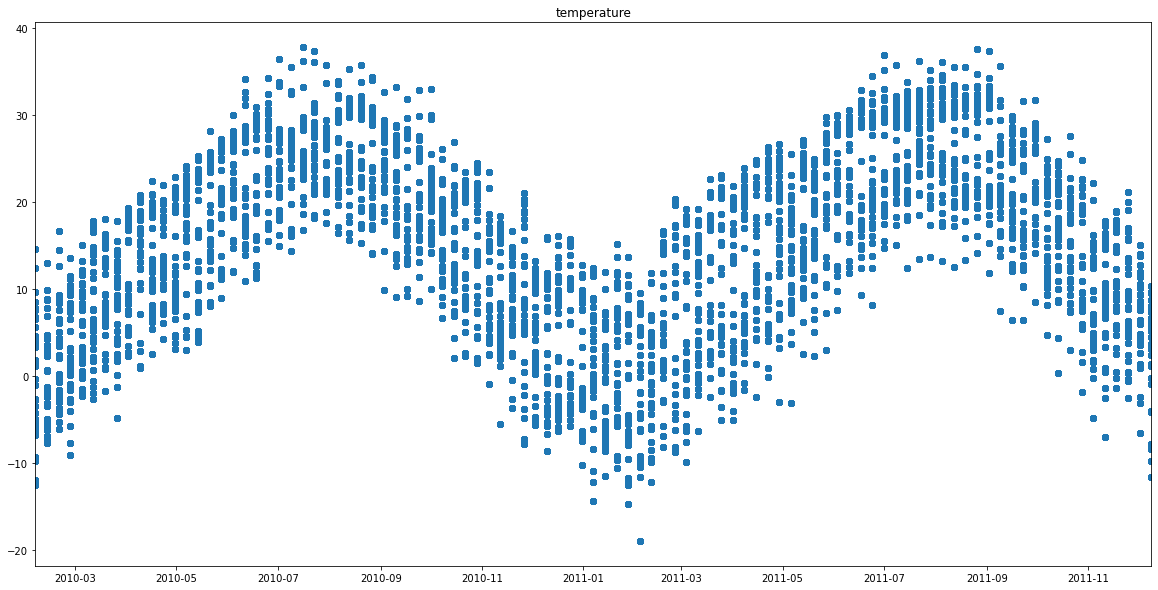

In [31]:
### Dealing with nan values in temperature column

plt.scatter(merged_df.index, merged_df.temperature)
plt.xlim(min(merged_df.index), max(merged_df.index))
plt.title('temperature')

Text(0.5, 1.0, 'fuel_price')

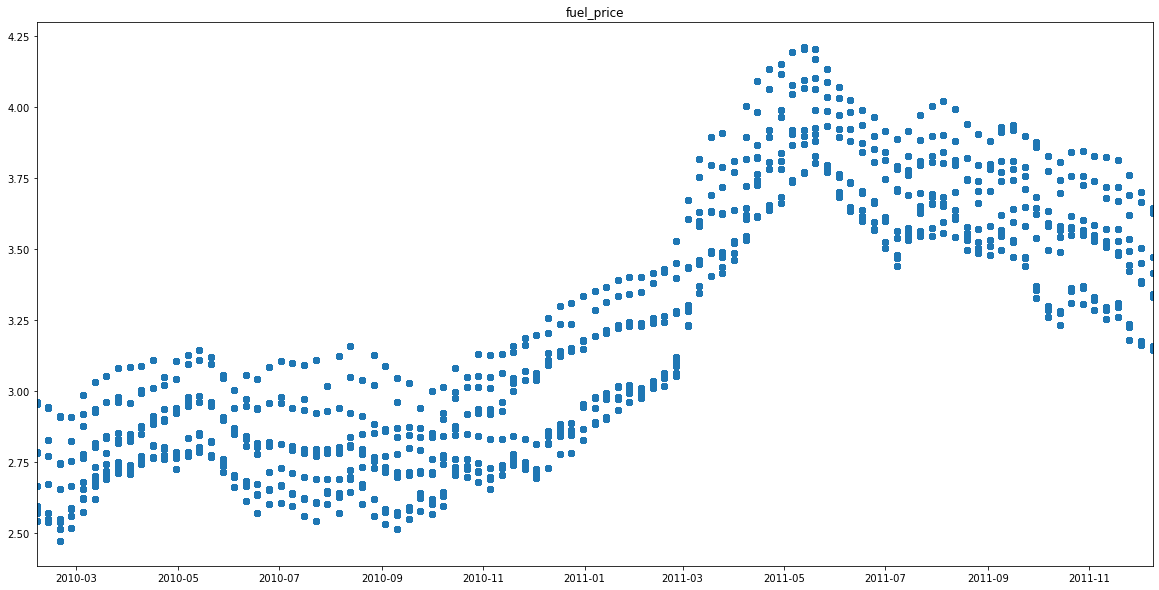

In [32]:
### Dealing with nan values in fuel_price column

plt.scatter(merged_df.index, merged_df.fuel_price)
plt.xlim(min(merged_df.index), max(merged_df.index))
plt.title('fuel_price')

Text(0.5, 1.0, 'cpi')

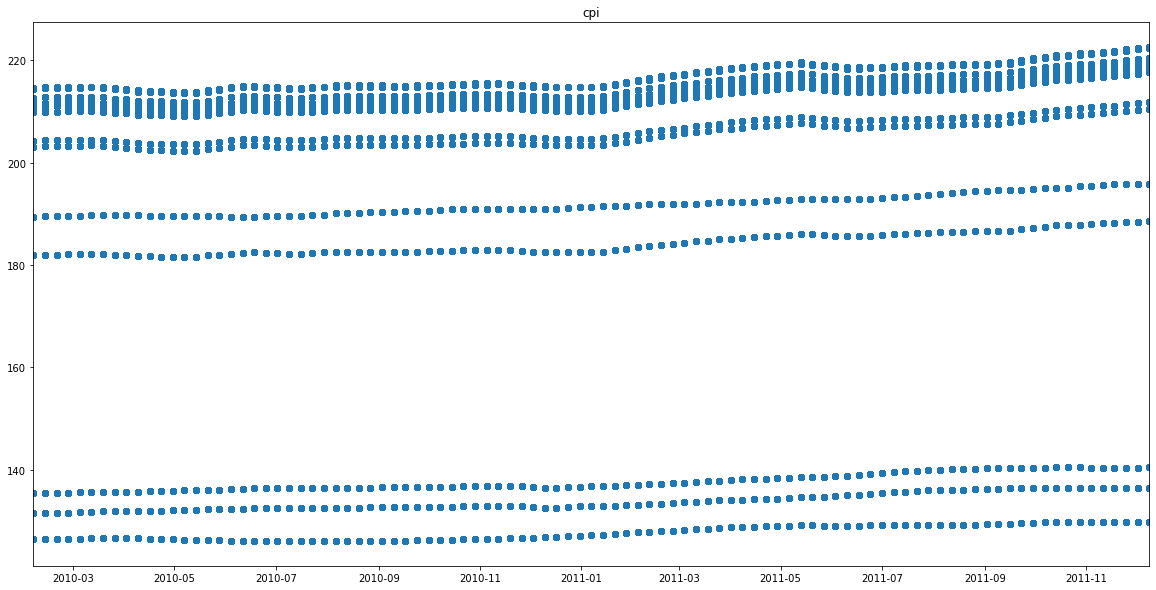

In [33]:
### Dealing with nan values in cpi column

plt.scatter(merged_df.index, merged_df.cpi)
plt.xlim(min(merged_df.index), max(merged_df.index))
plt.title('cpi')

Text(0.5, 1.0, 'unemployment')

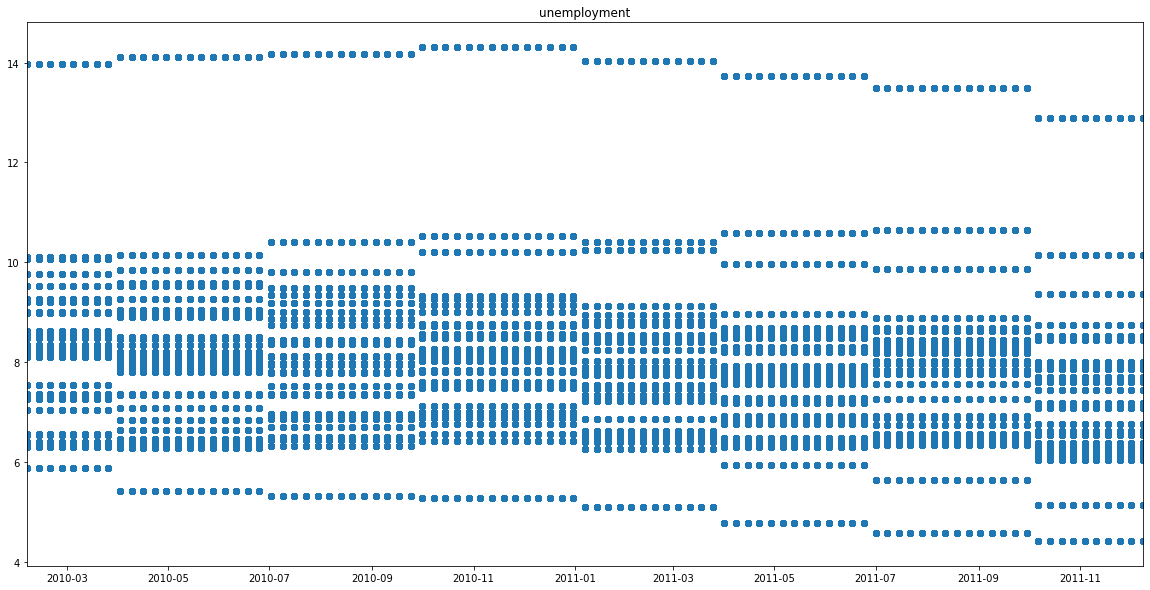

In [34]:
### Dealing with nan values in unemployment column

plt.scatter(merged_df.index, merged_df.unemployment)
plt.xlim(min(merged_df.index), max(merged_df.index))
plt.title('unemployment')

In [35]:
### operacje na datach

merged_df['month'] = merged_df.index.month
merged_df['year'] = merged_df.index.year
merged_df['week'] = merged_df.index.week
merged_df["dayofweek"] = merged_df.index.dayofweek
merged_df["dayofyear"] = merged_df.index.dayofyear

In [36]:
merged_df.sample(5)

,weekly_sales,store,dept,is_holiday,temperature,fuel_price,cpi,unemployment,Size,Type_B,Type_C,month,year,week,dayofweek,dayofyear
date,,,,,,,,,,,,,,,,
2011-01-21,3957.060059,13,30,0,1.555664,2.933594,127.4375,7.468750,219622,0,0,1,2011,3,4,21
2011-06-03,4812.399902,18,12,0,21.609375,3.972656,134.8750,8.976562,120653,1,0,6,2011,22,4,154
2011-01-07,6206.250000,35,42,0,1.344727,3.193359,136.7500,8.546875,103681,1,0,1,2011,1,4,7
2011-05-27,120.360001,33,9,0,27.953125,3.933594,129.0000,8.687500,39690,0,0,5,2011,21,4,147
2010-06-11,10329.179688,36,40,0,27.937500,2.615234,210.2500,8.460938,39910,0,0,6,2010,23,4,162


In [37]:
lag_weekly_sales = pd.DataFrame({'store':merged_df.index, 'weekly_sales': merged_df['weekly_sales']})

lag_weekly_sales['lag_weekly_sales_1'] = lag_weekly_sales['weekly_sales'].shift(1)
lag_weekly_sales['lag_weekly_sales_2'] = lag_weekly_sales['weekly_sales'].shift(2)
lag_weekly_sales['lag_weekly_sales_3'] = lag_weekly_sales['weekly_sales'].shift(3)
lag_weekly_sales['lag_weekly_sales_4'] = lag_weekly_sales['weekly_sales'].shift(4)
lag_weekly_sales['lag_weekly_sales_5'] = lag_weekly_sales['weekly_sales'].shift(5)

lag_weekly_sales.drop(['store', 'weekly_sales'], axis=1, inplace=True)

lag_weekly_sales

,lag_weekly_sales_1,lag_weekly_sales_2,lag_weekly_sales_3,lag_weekly_sales_4,lag_weekly_sales_5
date,,,,,
2010-07-09,NaN,NaN,NaN,NaN,NaN
2011-08-19,41272.601562,NaN,NaN,NaN,NaN
2011-06-10,6212.770020,41272.601562,NaN,NaN,NaN
2011-05-20,32530.310547,6212.770020,41272.601562,NaN,NaN
2010-09-10,6199.310059,32530.310547,6212.770020,41272.601562,NaN
...,...,...,...,...,...
2010-02-19,2016.000000,28515.650391,4765.000000,10844.879883,2610.889893
2010-07-16,3727.000000,2016.000000,28515.650391,4765.000000,10844.879883
2011-08-12,42387.859375,3727.000000,2016.000000,28515.650391,4765.000000


In [38]:
merged_df = pd.concat([merged_df, lag_weekly_sales], axis=1)

In [39]:
merged_df.sample(5)

,weekly_sales,store,dept,is_holiday,temperature,fuel_price,cpi,unemployment,Size,Type_B,...,month,year,week,dayofweek,dayofyear,lag_weekly_sales_1,lag_weekly_sales_2,lag_weekly_sales_3,lag_weekly_sales_4,lag_weekly_sales_5
date,,,,,,,,,,,,,,,,,,,,,
2011-08-26,70497.156250,14,93,0,22.531250,3.703125,186.625,8.625000,200898,0,...,8,2011,34,4,238,4294.740234,29824.060547,759.809998,4475.660156,959.479980
2010-08-13,25200.279297,27,97,0,25.203125,2.923828,136.500,7.980469,204184,0,...,8,2010,32,4,225,3.500000,171.529999,4030.979980,64.879997,3008.260010
2011-04-08,79.839996,43,5,0,21.312500,3.621094,206.875,10.578125,41062,0,...,4,2011,14,4,98,9016.049805,399.000000,532.590027,1933.000000,31340.900391
2011-02-18,2732.469971,24,12,0,1.133789,3.419922,133.375,8.250000,203819,0,...,2,2011,7,4,49,10402.070312,13682.339844,32192.009766,151.199997,1221.329956
2011-04-22,38384.628906,26,91,0,1.005859,3.919922,134.375,7.816406,152513,0,...,4,2011,16,4,112,70.010002,6976.740234,18201.179688,13345.919922,10969.389648


In [40]:
### Feature selection for models

In [41]:
obj_feats = merged_df.select_dtypes(include=['number', 'bool']).columns
black_list = ['id', 'weekly_sales']
feats = [x for x in obj_feats if x not in black_list]
feats

['store',
 'dept',
 'is_holiday',
 'temperature',
 'fuel_price',
 'cpi',
 'unemployment',
 'Size',
 'Type_B',
 'Type_C',
 'month',
 'year',
 'week',
 'dayofweek',
 'dayofyear',
 'lag_weekly_sales_1',
 'lag_weekly_sales_2',
 'lag_weekly_sales_3',
 'lag_weekly_sales_4',
 'lag_weekly_sales_5']

In [42]:
X = merged_df[feats]
y = merged_df['weekly_sales']

In [43]:
split = int(len(merged_df) * 0.7)

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [44]:
X_train.index

DatetimeIndex(['2010-07-09', '2011-08-19', '2011-06-10', '2011-05-20',
               '2010-09-10', '2010-06-25', '2011-10-28', '2011-07-29',
               '2010-12-31', '2011-02-25',
               ...
               '2010-08-27', '2011-05-27', '2011-09-16', '2010-08-06',
               '2011-06-10', '2010-11-05', '2011-02-18', '2011-12-02',
               '2010-02-05', '2011-07-08'],
              dtype='datetime64[ns]', name='date', length=199562, freq=None)

In [45]:
X_test.index

DatetimeIndex(['2011-04-29', '2010-11-19', '2010-09-24', '2011-08-26',
               '2011-09-30', '2011-05-27', '2011-08-26', '2011-07-29',
               '2010-12-24', '2010-12-03',
               ...
               '2010-02-19', '2010-09-03', '2010-09-17', '2010-05-21',
               '2011-03-25', '2010-02-19', '2010-07-16', '2011-08-12',
               '2011-05-13', '2010-11-19'],
              dtype='datetime64[ns]', name='date', length=85527, freq=None)

In [46]:
xgb_reg = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.3, verbosity=1, random_state=0)


xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [48]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False))

3776.7864


In [51]:
X = merged_df[feats]
y = merged_df['weekly_sales']


def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = np.empty((len(df_as_np)-window_size, window_size, 1))
    y = np.empty(len(df_as_np)-window_size)
    '''
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size].reshape((window_size, 1))
        X[i] = row
        label = df_as_np[i+window_size]
        y[i] = label
    '''
    return X, y


In [52]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(merged_df, WINDOW_SIZE)
print(X1, y1)

[[[4.67592952e-310]
  [6.92830883e-310]
  [4.67592952e-310]
  [4.67592349e-310]
  [4.94065646e-324]]

 [[0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]
  [4.94065646e-324]
  [0.00000000e+000]]

 [[0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]
  [0.00000000e+000]]

 ...

 [[1.13635099e-322]
  [2.07507571e-322]
  [6.91691904e-323]
  [1.23516411e-322]
  [2.96439388e-323]]

 [[2.47032823e-323]
  [1.28457068e-322]
  [2.56914136e-322]
  [6.42285340e-323]
  [6.42285340e-323]]

 [[1.03753786e-322]
  [1.13635099e-322]
  [6.91691904e-323]
  [1.13635099e-322]
  [2.37151510e-322]]] [4.67592362e-310 4.67592805e-310 4.67592362e-310 ... 9.19860393e+024
 8.32959463e+027 2.67994312e+022]


In [53]:
len_x = len(X1)
len_y = len(y1)

train_split = int(len_x*0.7)
test_split = int(len_x*0.9)

In [54]:
X_train1, y_train1 = X1[:train_split], y1[:train_split]
X_val1, y_val1 = X1[train_split:test_split], y1[train_split:test_split]
X_test1, y_test1 = X1[test_split:], y1[test_split:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((199558, 5, 1), (199558,), (57017, 5, 1), (57017,), (28509, 5, 1), (28509,))

In [55]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])